# Demo:  CNN Classifier for CIFAR10

In this demo, you will learn to:

* Load the classic CIFAR10 dataset from keras and visualize the images
* Train and test a simple CNN classifier for the dataset
* Enhance the classifiers with batch normalization, dropout and data augmentation and evaluate the relative performance gains.


The [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is a collection of 60,000 color, `32x32`-pixel images in ten classes. Classes include common objects such as airplanes, automobiles, birds, cats and so on. There are 50,000 train and 10,000 test images. Keras can automatically download the dataset from `keras.datasets`. Note that it will take some time to downloading the dataset for the first time. But, the download will be saved in cache and would not be needed to download again. 

State of the art results are achieved using very large Convolutional Neural networks. Model performance is reported in this [classification accuracy table](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130), with state-of-the-art results at 96.5% with human performance on the problem at 94%.  In this demo, we will use a very basic CNN.  With suitable enhancements we can performance ~78%.

Most of the code and the description in this demo is taken from `cifar10_cnn.py` available at [keras-team Github page](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) as well as from the tutorial page by [Jason Brownlee](https://machinelearningmastery.com/object-recognition-convolutional-neural-networks-keras-deep-learning-library/).  Also, thanks to [Phil Schniter](http://www2.ece.ohio-state.edu/~schniter/) for helping adjust some parameters.


## Loading Basic Packages

We first load some basic packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

from tensorflow.keras.datasets import cifar10
import pickle

This demo requires use of a GPU.  Otherwise, the fitting will be far too slow.  The following function is one way to test if your machine is using a GPU.

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 387720724492694467
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15703311680
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8126079203260770633
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


Create a 3×3 plot of photographs. The images have been scaled up from their small 32×32 size, but you can clearly see trucks horses and cars. You can also see some distortion in some images that have been forced to the square aspect ratio.

In [3]:
# load data
(Xtr,ytr), (Xts,yts) = cifar10.load_data()
ntr, nrow, ncol, nchan = Xtr.shape
nts = Xts.shape[0]

print('Xtr shape:  ' + str(Xtr.shape))
print('Xts shape:  ' + str(Xts.shape))

Xtr shape:  (50000, 32, 32, 3)
Xts shape:  (10000, 32, 32, 3)


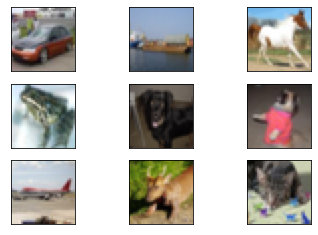

In [4]:
def plt_image(im):
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    
# Print a few random samples
nplot = 9
I = np.random.permutation(ntr)
for i in range(0, 9):
    plt.subplot(3,3,i+1)
    plt_image(Xtr[I[i]])

import some more packages for building CNN model and saving the trained model

In [5]:
from __future__ import print_function

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model #save and load models
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

The pixel values are in the range of 0 to 255 for each of the red, green and blue channels.

It is good practice to work with normalized data. Because the input values are well understood, we can easily normalize to the range 0 to 1 by dividing each value by the maximum observation which is 255.  Note, the data is loaded as integers, so we must cast it to floating point values in order to perform the division.

In [6]:
Xtr = Xtr.astype('float32') / 255.
Xts = Xts.astype('float32') / 255.

## Testing Different Classifiers

We now define a function to create a model.  The function has two paramters:

* `use_bn`:  Adds BatchNormalization
* `use_dropout`:  Adds Dropout layers

By setting the parameters, we can experiment with different model features and compare their performance.  The model has two convolutional layers + two FC layers.  Dropout, if added, is done on the FC layers.

In [7]:
def create_mod(use_dropout=False, use_bn=False):
    num_classes = 10
    model = Sequential()
    model.add(Conv2D(32, (3, 3), 
                     padding='valid', activation='relu',
                     input_shape=Xtr.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    if use_bn:
        model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    if use_bn:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu'))
    if use_bn:
        model.add(BatchNormalization())
    if use_dropout:
        model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

To study data augmentation, we also create an `ImageDataGenerator` object that will create augmented images for the training data set.

In [8]:
def create_datagen():
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)
    return datagen


Convert labels to categorical.

In [9]:
from tensorflow.keras.utils import to_categorical
n_classes = 10
ytr_cat = to_categorical(ytr, n_classes)
yts_cat = to_categorical(yts, n_classes)

Now, we run over all possible options:  The options are:
        
* `basic`:  Basic CNN, no batch normalization or dropout   
* `bn`:  Basic CNN + batch normalization
* `dropout`:  Basic CNN + batch normalization + dropout
* `dataaug`:  Basic CNN + batch normalization + dropout + data augmentation

This will take tens of minutes per model even on a GPU.  We save two files for each run: An `h5` model file and pickle file with the accuracy history.

In [10]:
mod_name_test = ['basic', 'bn', 'dropout', 'dataaug']
nmeth = len(mod_name_test)

# Parameters
nepochs = 100
batch_size = 32
lr = 1e-3
decay = 1e-4

# Main loop
for i, mod_name in enumerate(mod_name_test):

    # Create the model based on the model type
    K.clear_session()
    if mod_name == 'basic':
        model = create_mod()
    elif mod_name == 'bn':
        model = create_mod(use_bn=True)
    elif (mod_name == 'dropout') or (mod_name == 'dataaug'):
        model = create_mod(use_bn=True, use_dropout=True)        
    else:
        raise Exception('Model %s not known' % mod_name)

    # Create the optimizer
    opt = optimizers.Adam(lr=lr, decay=decay)

    # Compile
    hist = model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    print(model.summary()) 

    if mod_name == 'dataaug':

        
        
        # Create a data augmentation 
        datagen = create_datagen()

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(Xtr)

        # Fit the model on the batches generated by datagen.flow().
        hist = model.fit(datagen.flow(Xtr, ytr_cat,
                            batch_size=batch_size),
                            epochs=nepochs, validation_data=(Xts,yts_cat))

    else:
        # Fit the model with no data augmentation
        hist = model.fit(Xtr, ytr_cat, batch_size=batch_size,
              epochs=nepochs, validation_data=(Xts, yts_cat),
              shuffle=True)

    # Save model
    h5_fn = ('cifar_%s.h5' % mod_name)
    model.save(h5_fn)
    print('Model saved as %s' % h5_fn)

    # Save history
    hist_fn = ('hist_%s.p' % mod_name)
    with open(hist_fn, 'wb') as fp:
        hist_dict = hist.history
        pickle.dump(hist_dict, fp) 
    print('History saved as %s' % hist_fn)                                

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               590336    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

We now plot the results.  You should approximately get

* `baseline` ~70%
* `bn` ~74%
* `bn+dropout` ~78%
* `bn+dropout+augmentation` ~76%

So batch normalization and dropout help, but augmentation is not necessary in this case.  Note that `baseline` and `bn` get training accuracies of ~100% suggesting overfitting.

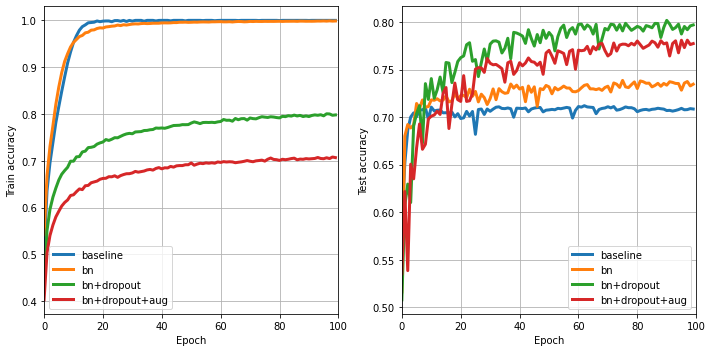

In [11]:
mod_name_plot = ['basic', 'bn', 'dropout', 'dataaug']
plt.figure(figsize=(10,5))
for iplt in range(2):
    
    plt.subplot(1,2,iplt+1)
    for i, mod_name in enumerate(mod_name_plot):

        # Load history
        hist_fn = ('hist_%s.p' % mod_name)
        with open(hist_fn, 'rb') as fp:        
            hist_dict = pickle.load(fp) 

        if iplt == 0:
            acc = hist_dict['accuracy']
        else:
            acc = hist_dict['val_accuracy']
        plt.plot(acc, '-', linewidth=3)
    
    n = len(acc)
    nepochs = len(acc)
    plt.grid()
    plt.xlim([0, nepochs])
    plt.legend(['baseline', 'bn', 'bn+dropout', 'bn+dropout+aug'])
    plt.xlabel('Epoch')
    if iplt == 0:
        plt.ylabel('Train accuracy')
    else:
        plt.ylabel('Test accuracy')
        
plt.tight_layout()

Print final accuracies:

In [12]:
for i, mod_name in enumerate(mod_name_plot):

    # Load history
    hist_fn = ('hist_%s.p' % mod_name)
    with open(hist_fn, 'rb') as fp:        
        hist_dict = pickle.load(fp) 
        
    # Print average of last 5 acc
    acc = hist_dict['val_accuracy']
    print('%15s :  %5.3f' % (mod_name, np.mean(acc[-5:])))

          basic :  0.708
             bn :  0.734
        dropout :  0.793
        dataaug :  0.778
